In [92]:
import pandas as pd
import seaborn as sns
from analysis_utils import plot_diff_in_bias, plot_grid_of_bias_diffs

# Simple example

In this case, we show the effect of in-sample vs. out-of-sample evaluation for a simple data-generating process, where $K=5$, $N=1000$, $d=2$, and the $y$ is continuous. 

In [93]:

# need `pyarrow` package to load parquet files
df = pd.read_csv('results_clust_dgp_check.csv')
df.head()

# set these for the subsequent analysis
K = 5
N = 1000
d= 2
method = 'hbac'
binary_y = False
bonf_corr = False
bootstrap_perm = False
df_simple = df[(df['K'] == K) & (df['N'] == N) & (df['method'] == method) & (df['d'] == d) & (df['binary_y'] == binary_y) & (df['bonf_correct'] == bonf_corr) & (df['bootstrap_perm'] == bootstrap_perm)]


# define for the plot
target_col_map = {'y': r'$y$', 'y_pred': r'$\hat{y}$', 'err': r'$(y - \hat{y})^2$'}



### (1) Without a difference in the metric, in-sample

Here, $y \sim \mathcal{N}(0, 1)$ for each cluster. Despite this, the clustering finds differences in the y - but this is only in-sample!

/Users/florisholstege/Documents/GitHub/unsupervised-bias-detection/paper_analysis/analysis_utils.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Cluster')


<Axes: xlabel='Bias metric', ylabel='Difference in Bias'>

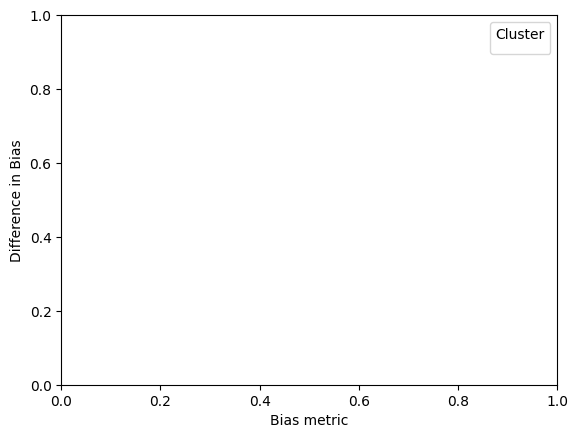

In [94]:
# select the df with specific train_fit
fit_train = False
y_dgp = 'constant'
df_simple_no_diff_in_sample = df_simple[(df_simple['fit_train'] == fit_train) & (df_simple['y_dgp'] == y_dgp)]

# create plot
plot_diff_in_bias(df_simple_no_diff_in_sample, target_col_map=target_col_map, color_set='Reds', show_legend='auto')

### (2) Without a difference in the metric, out-of-sample

There remains a difference in $\hat{y}$. My current hypothesis is that this is due because in each individual simulation, there are non-zero coefficients for the linear regression.

<Axes: xlabel='Bias metric', ylabel='Difference in Bias'>

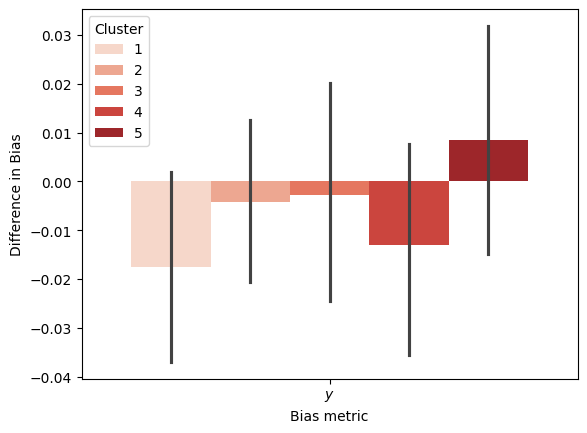

In [95]:


# select the df with specific train_fit
fit_train = True
y_dgp = 'constant'
df_simple_no_diff_out_sample = df_simple[(df_simple['fit_train'] == fit_train) & (df_simple['y_dgp'] == y_dgp)]

# create plot
plot_diff_in_bias(df_simple_no_diff_out_sample, target_col_map=target_col_map, color_set='Reds')

### (3) With difference in the metric, in-sample

Now, the expectation of $y$ linearly increases with the cluster $k$ between -1, 1:
$y \sim \mathcal{N}(\mu_k, 1)$, where $\mu_k = -1 + 2*(k/K)$

/Users/florisholstege/Documents/GitHub/unsupervised-bias-detection/paper_analysis/analysis_utils.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Cluster')


<Axes: xlabel='Bias metric', ylabel='Difference in Bias'>

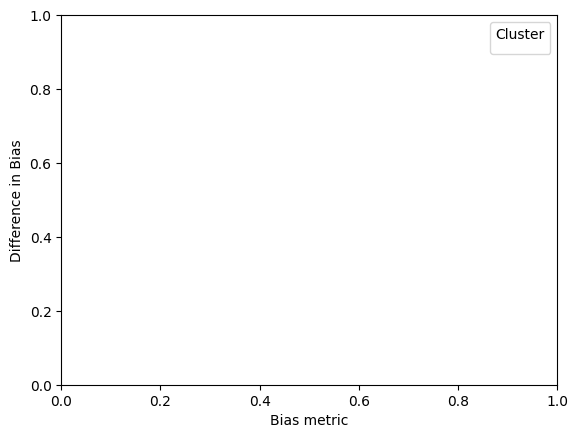

In [96]:


# select the df with specific train_fit
fit_train = False
y_dgp = 'constant'
df_simple_diff_in_sample = df_simple[(df_simple['fit_train'] == fit_train) & (df_simple['y_dgp'] == y_dgp)]

# create plot
plot_diff_in_bias(df_simple_diff_in_sample, target_col_map=target_col_map, color_set='Reds')


### (4) With difference in the metric, out-of-sample

Now, we see that this result is similar to the case when there is a difference in the metric. 

/Users/florisholstege/Documents/GitHub/unsupervised-bias-detection/paper_analysis/analysis_utils.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Cluster')


<Axes: xlabel='Bias metric', ylabel='Difference in Bias'>

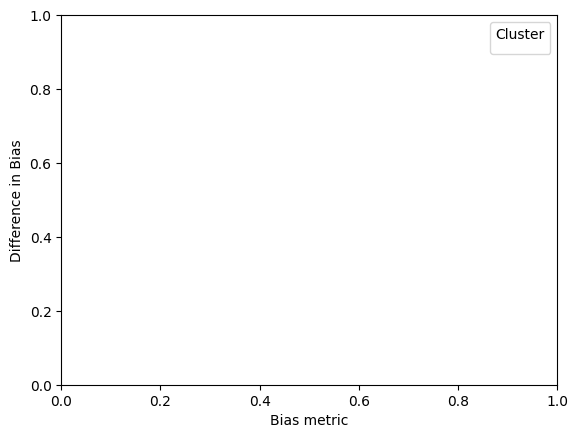

In [97]:

# select the df with specific train_fit
fit_train = True
y_dgp = 'linear'
df_simple_diff_out_sample = df_simple[(df_simple['fit_train'] == fit_train) & (df_simple['y_dgp'] == y_dgp)]

# create plot
plot_diff_in_bias(df_simple_diff_out_sample, target_col_map=target_col_map, color_set='Reds')


# Statistical testing

In [98]:

# select the df with specific fit_train
fit_train = True
method = 'hbac'
K = 5
N = 1000
d = 2
binary_y = False
x_dgp = 'random'
y_dgp = 'constant'
df_testing = df[(df['K'] == K) & (df['N'] == N) & (df['method'] == method) & (df['d'] == d) & (df['binary_y'] == binary_y) & (df['fit_train'] == fit_train) & (df['x_dgp'] == x_dgp) & (df['y_dgp'] == y_dgp)]


In [ ]:
def map_test_proc(bootstrap_perm, bonf_corr):
    if bootstrap_perm and bonf_corr:
        return 'bootstrap bonferoni'
    elif bootstrap_perm and not bonf_corr:
        return 'bootstrap, no bonferoni'
    elif bonf_corr and not bootstrap_perm:
        return 'No bootstrap, bonferoni'
    else:
        return 'No bootstrap, no bonferoni'
    

Text(58.399925781250005, 0.5, 'False positive rate')

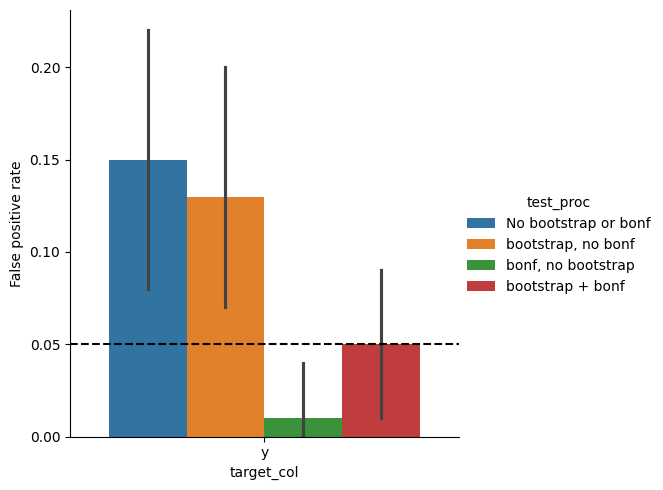

In [102]:
# define a column whether there is a significant difference in bias
df_testing['sig_clust'] = ((df_testing['p_clust'] < 0.05) & (df_testing['diff_clust'] > 0)).astype(int)
params = ['iter', 'N', 'K', 'target_col', 'method', 'bonf_correct', 'bootstrap_perm']
df_testing_avg = df_testing.groupby(params)['sig_clust'].mean().reset_index()
df_testing_avg['at_least_one'] = (df_testing_avg['sig_clust'] > 0).astype(int)

# Create a test-type column, which combines the bootstrap_perm and bonf_correct columns
df_testing_avg['test_proc'] = df_testing_avg.apply(lambda row: map_test_proc(row['bootstrap_perm'], row['bonf_correct']), axis=1)

g = sns.catplot(data=df_testing_avg, x='target_col', y='at_least_one', hue='test_proc', kind='bar')
g.ax.axhline(0.05, ls='--', c='k')
g.ax.set_ylabel("False positive rate")